
# **Використання часових рядів**

Цього разу будемо використовувати набір даних [Щоденні мінімальні температури в Мельбурні](https://github.com/jbrownlee/Datasets/blob/master/daily-min-temperatures.csv), який містить дані про щоденні мінімальні температури, зафіксовані в Мельбурні з 1981 по 1990 рік. Крім використання шарів Tensorflow для обробки послідовних даних, таких як рекурентні шари або LSTM, ви також будете використовувати конволюційні шари для покращення продуктивності моделі.


In [25]:
import csv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


In [26]:
"""This code downloads data from Dropbox"""

# Download the data from Dropbox
# and save it as 'data.zip'
!wget https://www.dropbox.com/scl/fi/w1vrq2fhh0x48x7brcbkc/data2.zip?rlkey=ow83fouvczlc2ghzv6epqonve&dl=0 -O data2.zip


/bin/bash: line 1: -O: command not found
--2023-09-06 17:50:59--  https://www.dropbox.com/scl/fi/w1vrq2fhh0x48x7brcbkc/data2.zip?rlkey=ow83fouvczlc2ghzv6epqonve
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/e/scl/fi/w1vrq2fhh0x48x7brcbkc/data2.zip?rlkey=ow83fouvczlc2ghzv6epqonve [following]
--2023-09-06 17:50:59--  https://www.dropbox.com/e/scl/fi/w1vrq2fhh0x48x7brcbkc/data2.zip?rlkey=ow83fouvczlc2ghzv6epqonve
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc017809098028d41d7a2c6a2818.dl.dropboxusercontent.com/cd/0/inline/CDOguIJwQTGG65EMmLEQ8ll7qJzZGWBhQijQH-lCq7pE3v10nt2zCpQQCYniEakq_VPcbJjfCI2zsYMy5himJq2PWmbytNSAHrTlogtcuFwBchiNX9hGNkU8I1tVf_x338pKNczvffE0hc6t-Oy31umq/file# [following]
--2023-09-06 17:51:00

In [27]:
from zipfile import ZipFile

def extract_zip_data(zipfilepath, target_dir):
  # Extract the zip file to the target directory
  with ZipFile(str(zipfilepath), 'r') as zipObj:
    zipObj.extractall(path=str(target_dir))

extract_zip_data(zipfilepath="/content/data2.zip?rlkey=ow83fouvczlc2ghzv6epqonve", target_dir="./")


In [28]:
filename = './data/daily-min-temperatures.csv'

with open(filename, 'r') as csvfile:
  print('--------------------------')
  print(f"Header:\n\n{csvfile.readline()}")
  print('--------------------------')
  print(f"1-ий рядок:\n\n{csvfile.readline()}")
  print('--------------------------')
  print(f"2-ий рядок:\n\n{csvfile.readline()}")
  print('--------------------------')


--------------------------
Header:

"Date","Temp"

--------------------------
1-ий рядок:

"1981-01-01",20.7

--------------------------
2-ий рядок:

"1981-01-02",17.9

--------------------------


In [29]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


## **Data**


In [30]:

times = []
temperatures = []

with open(filename) as csvfile:
  reader = csv.reader(csvfile, delimiter=",")
  for i, line in enumerate(reader):
    if i == 0:
      pass
    else:
      times.append(i-1)
      temperatures.append(float(line[1]))



In [31]:
times[:10], temperatures[:10]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [20.7, 17.9, 18.8, 14.6, 15.8, 15.8, 15.8, 17.4, 21.8, 20.0])

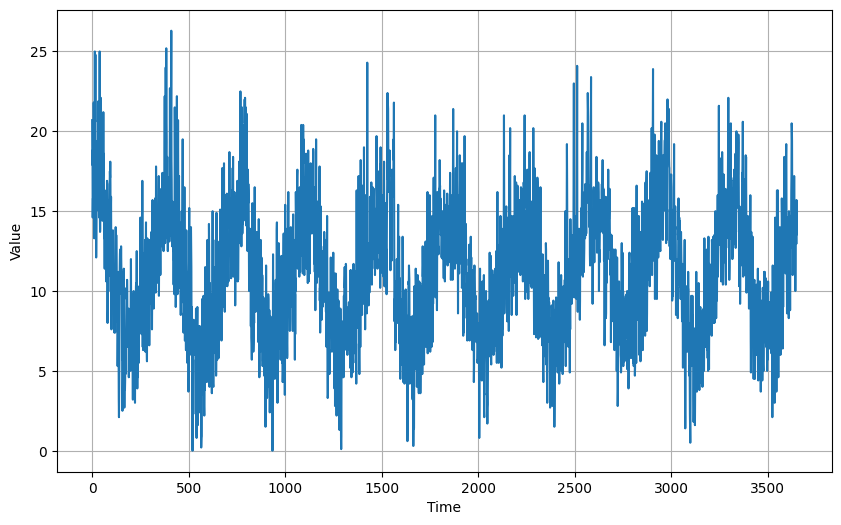

In [32]:

TIME = np.array(times)
SERIES = np.array(temperatures)
SPLIT_TIME = 2500
WINDOW_SIZE = 64
BATCH_SIZE = 256
SHUFFLE_BUFFER_SIZE = 1000

plt.figure(figsize=(10, 6))
plot_series(TIME, SERIES)
plt.show()


## **Data Processing**


In [33]:
SPLIT_TIME = 2500

def train_val_split(time, series, time_step=SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


In [34]:

# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)


In [35]:
time_train[:10], series_train[:10]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([20.7, 17.9, 18.8, 14.6, 15.8, 15.8, 15.8, 17.4, 21.8, 20. ]))

In [36]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER_SIZE):
    # Створюємо набір даних, розбиваючи вхідний ряд на окремі елементи
    ds = tf.data.Dataset.from_tensor_slices(series)

    # Створюємо "вікна" даних з розміром window_size + 1
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)

    # Перетворюємо вікна в пакети розміром window_size + 1
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))

    # Перемішуємо дані в наборі даних
    ds = ds.shuffle(shuffle_buffer)

    # Розділяємо кожен пакет даних на дві частини
    ds = ds.map(lambda w: (w[:-1], w[-1]))

    # Групуємо дані в пакети та оптимізуємо продуктивність завантаження даних
    ds = ds.batch(batch_size).prefetch(1)

    return ds


In [37]:
WINDOW_SIZE = 64
BATCH_SIZE = 256
SHUFFLE_BUFFER_SIZE = 1000

# Застосовуємо функцію до набору даних і зберігаємо результат
train_set = windowed_dataset(series_train, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER_SIZE)

train_set


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

## Визначення архітектури моделі

Використовуємо комбінацію шарів `Conv1D` та `LSTM`, за якими слідують шари `Dense`.


In [39]:
# [1,2,3,1,9,3,4]
# kernel_size=3, strides=1, padding="causal", filters=3
# xs = [0,0,1], [0,1,2],[1,2,3],...,[9,3,4]
# ws1 = [0.5,1,0.3]
# ws2 = [0.9,0.3,0.2]
# ws3 = [-0.1,0.8,0.1]
# bs = [0.3, 0.3, 0.2]


In [61]:

model = tf.keras.models.Sequential([
    # Конволюційний шар з 64 фільтрами, розміром ядра 10 та кроком 1. Використовується "causal" доповнення та активаційна функція "relu".
    tf.keras.layers.Conv1D(filters=64, kernel_size=10, strides=1, padding="causal", input_shape=[WINDOW_SIZE, 1],
                            activation="relu"),
    # Двонаправлений LSTM шар з 32 одиницями, який повертає послідовності.
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # Ще один двонаправлений LSTM шар, але з 16 одиницями.
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # Повнозв'язний шар з 30 одиницями та активаційною функцією "relu".
    tf.keras.layers.Dense(30, activation="relu"),
    # Повнозв'язний шар з 10 одиницями та активаційною функцією "relu".
    tf.keras.layers.Dense(10, activation="relu"),
    # Повнозв'язний шар з однією одиницею.
    tf.keras.layers.Dense(1),
    # Шар Lambda, який масштабує вихід до максимального значення SERIES.
    tf.keras.layers.Lambda(lambda x: x * SERIES.max())
])


In [62]:
try:
    model.predict(train_set)
except:
    print("Ваша поточна архітектура несумісна з віконним набором даних, спробуйте її налаштувати.")
else:
    print("Ваша поточна архітектура сумісна з віконним набором даних! :)")


10/10 [==============================] - 3s 110ms/step
Ваша поточна архітектура сумісна з віконним набором даних! :)



## **Налаштування швидкості навчання**

Це лише зміна швидкості навчання під час процесу навчання, щоб дати уявлення про розумну швидкість навчання, і це не слід плутати з вибором найкращої швидкості навчання. Це відомо як оптимізація гіперпараметрів.


In [63]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 64, 64)            704       
                                                                 
 bidirectional_10 (Bidirecti  (None, 64, 64)           24832     
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 32)               10368     
 onal)                                                           
                                                                 
 dense_15 (Dense)            (None, 30)                990       
                                                                 
 dense_16 (Dense)            (None, 10)                310       
                                                                 
 dense_17 (Dense)            (None, 1)                

In [69]:

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

# Select your optimizer
optimizer = tf.optimizers.Adam()

# Compile the model passing in the appropriate loss
model.compile(loss="Huber",
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
10/10 [==============================] - 15s 421ms/step - loss: 1.6478 - mae: 2.0927 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - 3s 280ms/step - loss: 1.6049 - mae: 2.0530 - lr: 1.1220e-04
Epoch 3/100
10/10 [==============================] - 4s 417ms/step - loss: 1.5968 - mae: 2.0445 - lr: 1.2589e-04
Epoch 4/100
10/10 [==============================] - 3s 275ms/step - loss: 1.5802 - mae: 2.0268 - lr: 1.4125e-04
Epoch 5/100
10/10 [==============================] - 3s 279ms/step - loss: 1.5759 - mae: 2.0239 - lr: 1.5849e-04
Epoch 6/100
10/10 [==============================] - 5s 427ms/step - loss: 1.5717 - mae: 2.0181 - lr: 1.7783e-04
Epoch 7/100
10/10 [==============================] - 3s 269ms/step - loss: 1.5828 - mae: 2.0295 - lr: 1.9953e-04
Epoch 8/100
10/10 [==============================] - 3s 269ms/step - loss: 1.5678 - mae: 2.0147 - lr: 2.2387e-04
Epoch 9/100
10/10 [==============================] - 4s 335ms/step - loss: 1.5443 - mae: 1.9871

In [70]:
preds = model.predict(train_set)

10/10 [==============================] - 4s 158ms/step


In [74]:
# import pandas as pd
# pd.DataFrame(preds).iloc[:,0].describe()

In [75]:
# import pandas as pd
# pd.DataFrame(series_train).iloc[:,0].describe()

In [76]:
# plt.scatter(series_train[:-64].reshape(-1), preds.reshape(-1))

(0.0001, 10.0, 0.0, 10.0)

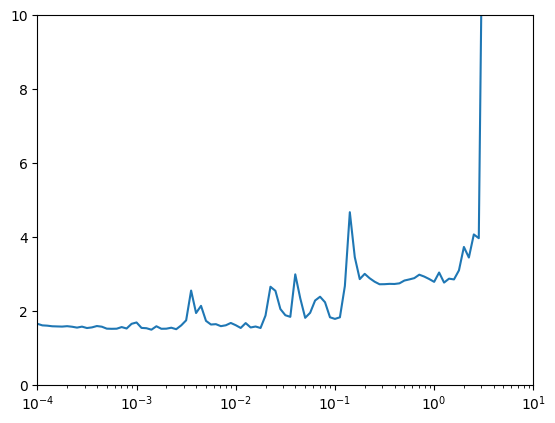

In [77]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 10, 0, 10])


## Компіляція моделі
- Якщо після першої епохи отримаємо loss: nan - mae: nan, можливо, у мережі проблема з вибуховими градієнтами. Якщо виникла ця проблема, знизьте швидкість навчання або використовуйте Adam зі стандартною швидкістю навчання.

In [78]:

model = tf.keras.models.Sequential([
    # Конволюційний шар з 64 фільтрами, розміром ядра 10 та кроком 1. Використовується "causal" доповнення та активаційна функція "relu".
    tf.keras.layers.Conv1D(filters=64, kernel_size=10, strides=1, padding="causal", input_shape=[WINDOW_SIZE, 1],
                            activation="relu"),
    # Двонаправлений LSTM шар з 32 одиницями, який повертає послідовності.
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # Ще один двонаправлений LSTM шар, але з 16 одиницями.
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # Повнозв'язний шар з 30 одиницями та активаційною функцією "relu".
    tf.keras.layers.Dense(30, activation="relu"),
    # Повнозв'язний шар з 10 одиницями та активаційною функцією "relu".
    tf.keras.layers.Dense(10, activation="relu"),
    # Повнозв'язний шар з однією одиницею.
    tf.keras.layers.Dense(1),
    # Шар Lambda, який масштабує вихід до максимального значення SERIES.
    tf.keras.layers.Lambda(lambda x: x * SERIES.max())
])

model.compile(loss="Huber",
              optimizer=tf.optimizers.Adam(learning_rate=0.0005),
              metrics=["mae"])


In [79]:

# Train it
history = model.fit(train_set, epochs=50)


Epoch 1/50
10/10 [==============================] - 14s 291ms/step - loss: 4.0172 - mae: 4.4894
Epoch 2/50
10/10 [==============================] - 5s 454ms/step - loss: 2.2234 - mae: 2.6797
Epoch 3/50
10/10 [==============================] - 3s 298ms/step - loss: 2.0072 - mae: 2.4594
Epoch 4/50
10/10 [==============================] - 5s 452ms/step - loss: 1.8828 - mae: 2.3360
Epoch 5/50
10/10 [==============================] - 5s 453ms/step - loss: 1.8191 - mae: 2.2735
Epoch 6/50
10/10 [==============================] - 3s 305ms/step - loss: 1.7959 - mae: 2.2473
Epoch 7/50
10/10 [==============================] - 3s 294ms/step - loss: 1.7997 - mae: 2.2556
Epoch 8/50
10/10 [==============================] - 5s 395ms/step - loss: 1.7611 - mae: 2.2111
Epoch 9/50
10/10 [==============================] - 4s 314ms/step - loss: 1.7241 - mae: 2.1749
Epoch 10/50
10/10 [==============================] - 4s 365ms/step - loss: 1.6968 - mae: 2.1468
Epoch 11/50
10/10 [=============================

## **Оцінка прогнозу**

In [80]:
def model_forecast(model, series, window_size):
    # 1. Створюємо набір даних з вхідної послідовності 'series'.
    ds = tf.data.Dataset.from_tensor_slices(series)

    # 2. Розбиваємо цей набір даних на вікна розміром 'window_size'. Кожне нове вікно зсувається на 1 позицію вперед.
    # 'drop_remainder=True' гарантує, що всі вікна матимуть однаковий розмір.
    ds = ds.window(window_size, shift=1, drop_remainder=True)

    # 3. Конвертуємо кожне вікно в пакет даних розміром 'window_size'. Це перетворює вікна в плоскі пакети даних.
    ds = ds.flat_map(lambda w: w.batch(window_size))

    # 4. Групуємо дані у пакети розміром 32 для швидшого прогнозування. 'prefetch(1)' дозволяє моделі обробляти один пакет даних,
    # поки наступний пакет завантажується, оптимізуючи час обчислень.
    ds = ds.batch(32).prefetch(1)

    # 5. Використовуючи модель, робимо прогноз для кожного пакета вікон в 'ds'.
    forecast = model.predict(ds)

    # 6. Повертаємо отримані прогнози.
    return forecast


113/113 [==============================] - 5s 32ms/step


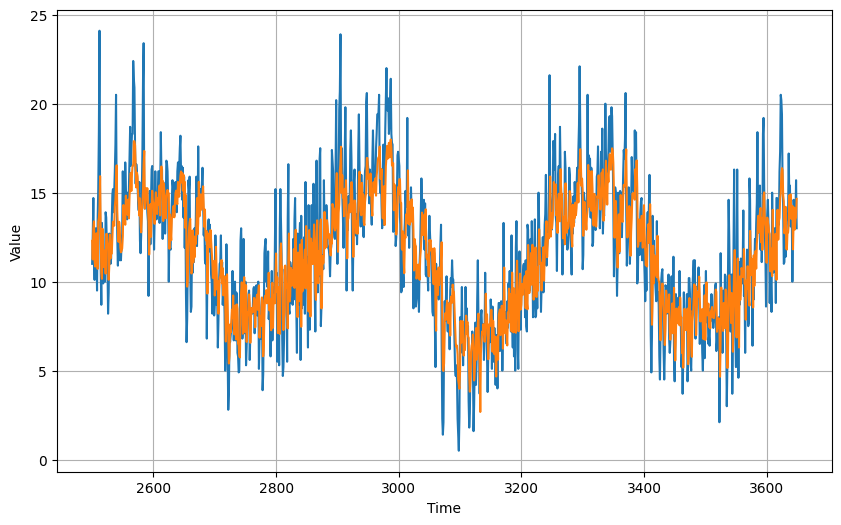

In [81]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, SERIES, WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[SPLIT_TIME - WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [82]:
mse = tf.keras.metrics.mean_squared_error(series_valid, rnn_forecast).numpy()
mae = tf.keras.metrics.mean_absolute_error(series_valid, rnn_forecast).numpy()

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.31, mae: 1.79 for forecast


In [83]:
# Save model in the SavedModel format
model.save('saved_model/my_model')

# Compress the directory using tar
! tar -czvf saved_model.tar.gz saved_model/

saved_model/
saved_model/my_model/
saved_model/my_model/variables/
saved_model/my_model/variables/variables.index
saved_model/my_model/variables/variables.data-00000-of-00001
saved_model/my_model/saved_model.pb
saved_model/my_model/assets/
saved_model/my_model/fingerprint.pb
saved_model/my_model/keras_metadata.pb
